<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/CNN_Tom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import matplotlib.pyplot as plt
import math
import getpass

#  for LeNet-5
from sklearn.model_selection import train_test_split
# import tensorflow as tf
# import keras
# import keras.layers as layers
# from keras.models import Sequential
# from keras.preprocessing.image import ImageDataGenerator
# from keras.utils.np_utils import to_categorical
# from keras.callbacks import TensorBoard


# for  3D CNN
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical

In [2]:
if 'Tom' not in getpass.getuser():
    from google.colab import drive
    drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
data = np.load('train.npz') if 'Tom' in getpass.getuser() else np.load('/content/gdrive/MyDrive/Colab Notebooks/train.npz') 

In [4]:
# separate bands and labels:
train_data = data['bands']
labels = data['lulc']

In [14]:
# remove no_data
labels_no_data = labels[labels != 0]
train_data_no_data = train_data[labels != 0, :, :, :, :]
print(labels_no_data.shape)
print(train_data_no_data.shape)

(8692,)
(8692, 12, 33, 33, 6)


In [6]:
# add class labels manually
classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

In [9]:
np.histogram(labels_no_data, bins=list(range(len(classes) + 1)))

(array([   0,  238, 5796, 1125,  770,   58,    0,    0,  217,  488,    0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))

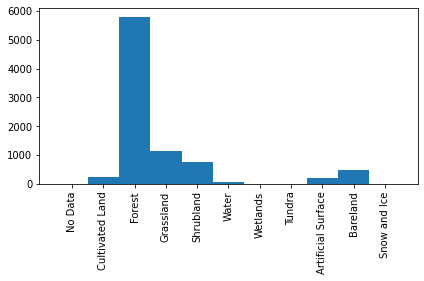

In [10]:
plt.hist(labels_no_data, bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

# **Experimental CNN**

In [11]:
train_labels_count = np.unique(labels, return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,1308
1,1,238
2,2,5796
3,3,1125
4,4,770
5,5,58
6,8,217
7,9,488


In [16]:
train = {}
validation = {}
# with no_data removed
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train_data_no_data, labels_no_data, test_size=0.2, random_state=0)

In [17]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 6953
# of validation images: 1739


In [18]:
val = validation['labels']
train['labels'] = to_categorical(train['labels'], 11)
validation['labels'] = to_categorical(validation['labels'], 11)

In [ ]:
# Try Google's LeNet-5

# model = keras.Sequential()

# model.add(layers.Conv3D(filters=6, kernel_size=(1, 1, 1), activation='relu', input_shape=(12,33,33,6)))
# model.add(layers.AveragePooling3D())

# model.add(layers.Conv3D(filters=16, kernel_size=(1, 1, 1), activation='relu'))
# model.add(layers.AveragePooling3D())

# model.add(layers.Flatten())

# model.add(layers.Dense(units=120, activation='relu'))

# model.add(layers.Dense(units=84, activation='relu'))

# model.add(layers.Dense(units=11, activation = 'softmax'))

In [19]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12,33,33,6)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(11, activation='softmax'))

# Compile the model
model.compile(
    'Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 31, 31, 32)    5216      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 15, 15, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 15, 15, 32)     128       
_________________________________________________________________
dropout (Dropout)            (None, 5, 15, 15, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 13, 13, 64)     55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 6, 6, 64)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 6, 6, 64)       2

In [20]:
# Fit data to model
# history = model.fit(train_data, labels,
#             batch_size=128,
#             epochs=5,
#             verbose=1,
#             validation_split=0.2)

history = model.fit(train['features'], train['labels'], batch_size=64, epochs=50, validation_data=(validation['features'], validation['labels']))

Epoch 1/50
109/109 [==============================] - 57s 97ms/step - loss: 1.4736 - accuracy: 0.6036 - val_loss: 1.5779 - val_accuracy: 0.6642
Epoch 2/50
109/109 [==============================] - 10s 92ms/step - loss: 0.8095 - accuracy: 0.7236 - val_loss: 1.4744 - val_accuracy: 0.7050
Epoch 3/50
109/109 [==============================] - 10s 88ms/step - loss: 0.7243 - accuracy: 0.7516 - val_loss: 1.0764 - val_accuracy: 0.6740
Epoch 4/50
109/109 [==============================] - 10s 92ms/step - loss: 0.6719 - accuracy: 0.7679 - val_loss: 1.4189 - val_accuracy: 0.6814
Epoch 5/50
109/109 [==============================] - 10s 88ms/step - loss: 0.6785 - accuracy: 0.7694 - val_loss: 0.9073 - val_accuracy: 0.7320
Epoch 6/50
109/109 [==============================] - 10s 89ms/step - loss: 0.6013 - accuracy: 0.7897 - val_loss: 1.0792 - val_accuracy: 0.6935
Epoch 7/50
109/109 [==============================] - 10s 89ms/step - loss: 0.5964 - accuracy: 0.7919 - val_loss: 0.8059 - val_accuracy:

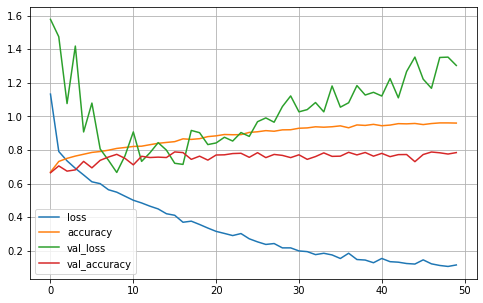

In [21]:
df = pd.DataFrame(history.history).plot(figsize=(8, 5))
df.plot(figsize=(8,5))
plt.grid(True)
plt.show()


In [22]:
preds = model.predict(validation['features'])
np.histogram(preds.argmax(1), bins=list(range(len(classes) + 1)))

(array([   0,   40, 1221,  208,  121,    9,    0,    0,   18,  122,    0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))

In [ ]:
# Till's plot

# true = val
# print(val)
# pred = preds
# plt.figure(figsize=[15, 10])
# plt.hist([true, pred], width = 0.25, histtype='bar', weights=[(np.zeros_like(true) + 1. / true.size), (np.zeros_like(pred) + 1. / pred.size)], align='mid')
# plt.legend(['y True', 'y Prediction'])
# plt.xticks([i + 0.25 for i in range(len(classes))], classes)
# plt.show()

In [32]:
# reshape labels
# val_labels = list()
# for i in range(validation['labels'].shape[0]):
#   values.index(max(values))

print(validation['labels'].shape[0])
print(labels_no_data)

1739
[3 2 2 ... 9 9 4]


[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
[3 2 2 ... 9 9 4]


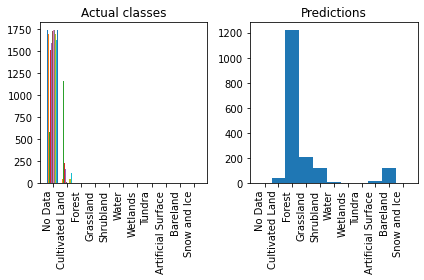

In [28]:
f, axes = plt.subplots(1, 2)


axes[0].hist(validation['labels'], bins=list(range(len(classes) + 1)))
axes[0].set_xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))))
axes[0].set_xticklabels(classes, rotation=90, ha='right')
axes[0].set_title('Actual classes')

axes[1].hist(preds.argmax(1), bins=list(range(len(classes) + 1)))
axes[1].set_xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))))
axes[1].set_xticklabels(classes, rotation=90, ha='right')
axes[1].set_title('Predictions')

plt.tight_layout()
plt.show()